In [157]:
%pylab inline
from lib import price_utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
reload(price_utils)


Populating the interactive namespace from numpy and matplotlib


<module 'lib.price_utils' from 'lib/price_utils.pyc'>

# Top savings grouped by CCG

The SQL for this is abstracted into the `price_utils` library, q.v. for details.

We normalise prescriptions to their generic equivalent (where possible), and exclude specials.

The following is sorted by possible savings at the top decile.

In [3]:
top_1000_ccg = price_utils.get_savings(group_by='pct')

In [4]:
top_1000_ccg.head()

,bnf_presentation,savings_presentations_pct,savings_generic_presentation,savings_deciles_lowest_decile,savings_quantity,savings_price_per_dose,savings_possible_savings
0,Fluticasone/Salmeterol_Inh 250/25mcg120D,13P,0302000N0AABGBG,41.345556,3151,54.829111,42486.684444
1,Glycopyrronium Brom_Inh Cap 55mcg + Dev,06M,0301020S0AAAAAA,0.849667,19853,2.442103,31614.637667
2,Fluticasone/Salmeterol_Inh 250/25mcg120D,01H,0302000N0AABGBG,41.345556,2474,53.795513,30801.195556
3,Glycopyrronium Brom_Inh Cap 55mcg + Dev,06L,0301020S0AAAAAA,0.849667,15511,2.794617,30168.130333
4,Budesonide/Formoterol Inh B/A 200/6(120D,99P,0302000K0AAAMAM,27.780000,4841,33.967649,29954.410000


## Grouped by CCG

The same data as above, but grouped by CCG

In [5]:
by_ccg = top_1000_ccg.groupby('savings_presentations_pct')['savings_possible_savings'] \
  .agg({'Count': 'count', 'Total savings': 'sum'}).sort_values('Total savings', ascending=False)
by_ccg.head()

,Count,Total savings
savings_presentations_pct,,
11J,29,282893.573741
99P,20,238082.988693
13P,23,230662.363842
09G,23,189868.975814
11N,22,183597.504930


In [6]:
by_ccg['Total savings'].sum()

7540482.0404408975

## Just focusing on Rich's CCG

In [7]:
by_ccg.loc('savings_presentations_pct')['99P']

Count                20.000000
Total savings    238082.988693
Name: 99P, dtype: float64

In [9]:
asd = price_utils.get_savings(for_entity='99P', group_by='pct')

In [10]:
asd.head()

,bnf_presentation,savings_presentations_pct,savings_generic_presentation,savings_deciles_lowest_decile,savings_quantity,savings_price_per_dose,savings_possible_savings
0,Budesonide/Formoterol Inh B/A 200/6(120D,99P,0302000K0AAAMAM,27.780000,4841,33.967649,29954.410000
1,Fluticasone/Salmeterol_Inh 250/25mcg120D,99P,0302000N0AABGBG,41.345556,2301,54.317905,29849.376667
2,Fluticasone/Salmeterol_Inh 125/25mcg120D,99P,0302000N0AABFBF,24.330333,3012,32.087905,23365.806000
3,Budesonide/Formoterol Inh B/A 400/12(60D,99P,0302000K0AAAUAU,27.779231,3673,33.594503,21359.495385
4,Beclomet Diprop_Inha 100mcg (200 D) CFF,99P,0302000C0AABFBF,6.883333,5716,10.062565,18172.486667


In [209]:
# Save it to a cSV

asd.to_csv("99P-full.csv")

# Same thing for practices

In [12]:
top_1000_practice = price_utils.get_savings(group_by='practice')

In [13]:
top_1000_practice.head()

,bnf_presentation,savings_presentations_practice,savings_generic_presentation,savings_deciles_lowest_decile,savings_quantity,savings_price_per_dose,savings_possible_savings
0,SMA Alfamino_Pdr,E87754,090900000BBKWA0,0.053280,20000,0.852444,15983.290000
1,"Dalteparin Sod_Inj 25,000u/ml 0.6ml Pfs",J81033,0208010L0AAAHAH,7.846624,112,106.709375,11072.628108
2,Sod Phenylbut_Liq Spec 1.25g/5ml,J82034,0908010P0AAAEAE,0.914930,2500,5.162388,10618.645595
3,"Dalteparin Sod_Inj 25,000u/ml 0.6ml Pfs",E82008,0208010L0AAAHAH,7.846624,100,106.708000,9886.137596
4,Influenza_Vac Inact 0.5ml Pfs,B84006,1404000H0AAAFAF,5.366000,2400,9.210100,9225.840000


In [17]:

top_1000_practice.to_csv("practices.csv")

# Is the quantity column dirty?

The "quantity" column is meant to indicate number of doses, but we think it is sometimes used to indicate number of packets.

What can we do to validate and/or clean up this data?

First, if we can assume the incorrect transcription is randomly distributed, we can attempt to detect such errors and then drop them from the dataset.

* Where `items` is the same as `quantity`
* Where `quantity` is one
* Where the price-per-dose is a close multiple of a known price-per-packet

## Can we work out pack size programmatically?

We happen to know that the pack size for Glycopyrronium is 30 - can we use this knowledge to validate an approach for guessing pack sizes?

This approach computes the factors of each quantity and then counts the occurence of each factor.

In [158]:

sql = '''
CREATE TEMPORARY FUNCTION
  factors(num INT64)
  RETURNS ARRAY<INT64>
  LANGUAGE js AS """
 var n_factors = [], i;
 var max_factor = 5000;
 if (num === 1) {
   n_factors.push(1); // we want to count instances where it's exactly 1
 }
 for (i = 1; i <= Math.min(Math.floor(Math.sqrt(num)), Math.floor(Math.sqrt(max_factor))); i += 1)

  if (num % i === 0) {
    n_factors.push(i);
    if (num / i !== i && num / i <= max_factor)
      n_factors.push(num / i);
 }
 return n_factors;
""";
SELECT
  factor
FROM
  ebmdatalab.hscic.prescribing,
  UNNEST(factors(quantity)) AS factor
WHERE
  bnf_code = '0301020S0AAAAAA'
  AND month = TIMESTAMP('2016-08-01')
'''
df = pd.io.gbq.read_gbq(sql, project_id="ebmdatalab", verbose=False, dialect='standard')



You can definitely infer the pack size in this example, by factorising each quantity and then sorting by numbers of factors; the sudden drop at 30 indicates the max pack size:

In [159]:
df.groupby('factor')['factor'].count().sort_values(ascending=False).head(10)

factor
1     2136
2     1839
3     1769
5     1733
6     1725
10    1719
15    1717
30    1717
4      701
12     645
Name: factor, dtype: int64

# Comparing the price-per-pill at each quantity level

The following query (one month of Glycopyrronium as per the above examples) adds a new element to the price per dose calculation. 

We calculate a "broken amount", which is the count of pills/doses in excess of a whole pack size.

We calculate an "optimum price per dose" which is based on the average price-per-dose at whole pack sizes, and we work out what we would *expect* the total cost to be, based on this per-unit price.



In [261]:
sql = """
WITH
  prescribing AS (
  SELECT
    *
  FROM
    ebmdatalab.hscic.prescribing
  WHERE
    bnf_code = '0301020S0AAAAAA'
    AND month = TIMESTAMP('2016-08-01'))
SELECT
  quantity,
  items,
  (quantity * optimum_price_per_dose) AS should_have_paid,
  actual_cost AS actually_paid,
  actual_cost - (quantity * optimum_price_per_dose) AS premium_paid,
  MOD(quantity, 30) AS broken_amount,
  IF (MOD(quantity, 30) > 0,
    IF(actual_cost > quantity * optimum_price_per_dose,
      IEEE_DIVIDE(actual_cost - (quantity * optimum_price_per_dose), MOD(quantity, 30)),
      0),
    0) AS premium_per_broken,
  pct,
  practice,
  optimum_price_per_dose,
  actual_cost/quantity AS price_per_dose
FROM
  prescribing,
  (
  SELECT
    AVG(quantity/actual_cost) AS optimum_price_per_dose
  FROM
    prescribing
  WHERE
    MOD(quantity, 30) = 0)
"""
df = pd.io.gbq.read_gbq(sql, project_id="ebmdatalab", verbose=False, dialect='standard')

In [262]:
df.head()

,quantity,items,should_have_paid,actually_paid,premium_paid,broken_amount,premium_per_broken,pct,practice,optimum_price_per_dose,price_per_dose
0,30,1,35.263422,25.49,-9.773422,0,0.0,06T,Y00484,1.175447,0.849667
1,91,4,106.965712,101.97,-4.995712,1,0.0,11X,L85015,1.175447,1.120549
2,90,3,105.790265,76.48,-29.310265,0,0.0,05H,M84011,1.175447,0.849778
3,90,3,105.790265,76.47,-29.320265,0,0.0,04Y,Y02354,1.175447,0.849667
4,30,1,35.263422,25.49,-9.773422,0,0.0,00J,A83029,1.175447,0.849667


In [263]:
#all_possible = pd.Series(range(0, df['quantity'].max() + 1)).rename('quantity')
#missing = all_possible[~all_possible.isin(df['quantity'])].to_frame()

If we just plot price per dose against quantity, we see the huge outliers at the £25 per dose mark where quantity is near 1.  £25 is roughly the price of a pack of 30 doses, which leads us to assume an error in the data.

We can also see a clear trend towards the price per dose varying less with greater quantities, which is not surprising.

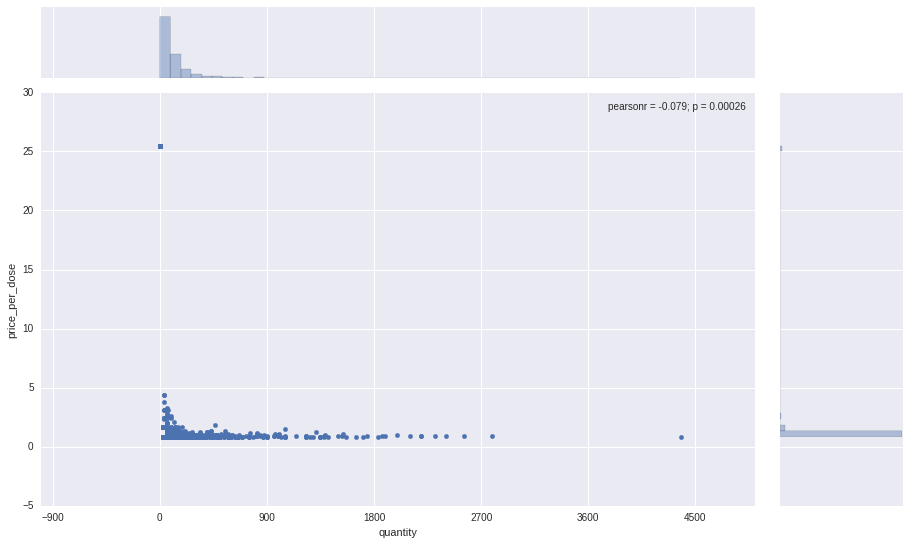

In [264]:
g = sns.jointplot("quantity", "price_per_dose", data=df2, kind="scatter")
import matplotlib.ticker as ticker
g.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(900))
g.fig.set_figwidth(14)
g.fig.set_figheight(8)

In [265]:
df[df['price_per_dose'] > 20].head()

,quantity,items,should_have_paid,actually_paid,premium_paid,broken_amount,premium_per_broken,pct,practice,optimum_price_per_dose,price_per_dose
55,1,1,1.175447,25.49,24.314553,1,24.314553,07T,F84021,1.175447,25.49
154,1,1,1.175447,25.49,24.314553,1,24.314553,00Y,P85601,1.175447,25.49
237,1,1,1.175447,25.49,24.314553,1,24.314553,05P,Y03965,1.175447,25.49
421,1,1,1.175447,25.49,24.314553,1,24.314553,05Y,M91020,1.175447,25.49
472,1,1,1.175447,25.49,24.314553,1,24.314553,06N,E82045,1.175447,25.49


What if we plot the *total premium paid* against quantity over what would be expected (in these calculations, this means at a per-unit cost of £1.17)?

We see a clear linear increase in cost savings across quantity. This is to be expected, as the prices paid to dispensers is discounted at a constant rate proportional to the quantity, on the assumption that they are able to secure bulk savings.

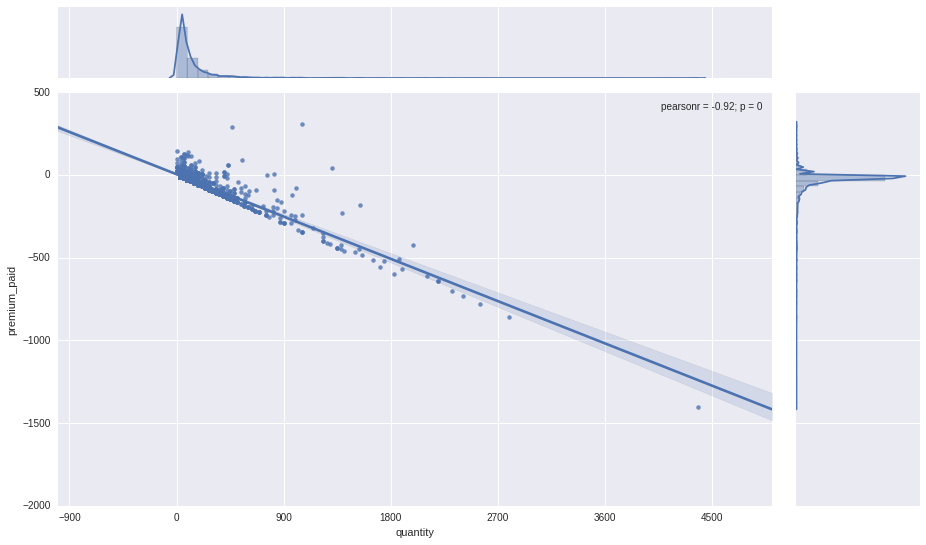

In [266]:
g = sns.jointplot("quantity", "premium_paid", data=df2, kind="reg")
import matplotlib.ticker as ticker
g.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(900))
g.fig.set_figwidth(14)
g.fig.set_figheight(8)

It gets more interesting if we zoom in, so that we can see at the scale of a typical packet size.  Here we can see that the premium paid shoots up very fast at small increments above the packet size. We also see that all quantities that don't match the packet size are just slightly larger than the packet size -- not less. 

Similarly, we can see a series of linear progressions above and parallel to the main regression line, which tells us that the excess cost is constant at each level of excess dose above the standard packet size.

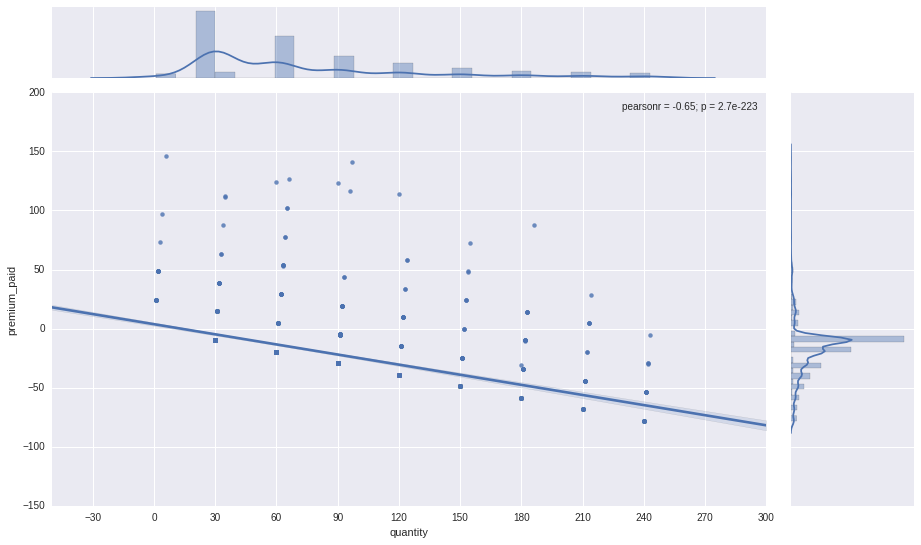

In [267]:
g = sns.jointplot("quantity", "premium_paid", data=df2[df2['quantity'] < 260], kind="reg")
import matplotlib.ticker as ticker
g.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(30))
g.fig.set_figwidth(14)
g.fig.set_figheight(8)

It looks to me like items where the quantity is 1 are not transcription errors, but where the quantity really is one, and a whole pack has been charged for.

We can attempt to verify this by looking only at "broken packs", and dividing the premium paid by the possible number of broken packs (estimated by taking the remainder when the quantity is divided by 30, and only looking where the total quantity is less than 40).

The first plot shows very tight clustering around £24 excess for quantities of less than 30:

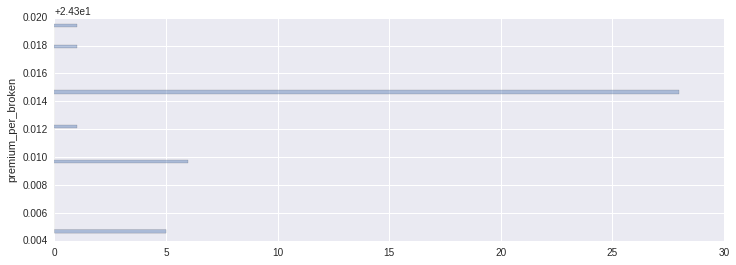

In [268]:


g = sns.distplot(
    df[(df['premium_per_broken'] > 0) & (df['quantity'] > 0) & (df['quantity'] < 30)]['premium_per_broken'], 
    bins=60, kde=False, vertical=True)


At quantities of between 30 and 60, the excess paid is almost always just less than £15.

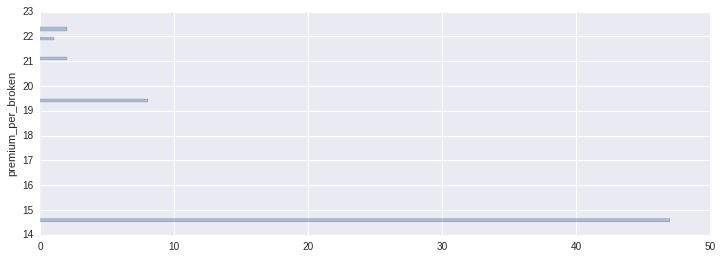

In [269]:

g = sns.distplot(
    df[(df['premium_per_broken'] > 0) & (df['quantity'] > 30) & (df['quantity'] < 60)]['premium_per_broken'], 
    bins=60, kde=False, vertical=True)